In [55]:
image_folder = '../Image Data/Monuments/train/Ajanta Caves'
embedding_size = 128
model_name = 'InceptionV3'
kmeans_model_path = 'inception_kmeans_model.pkl'

1/1 [==============================] - 0s 49ms/step


/Users/hanoon/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hanoon/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hanoon/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/hanoon/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarni

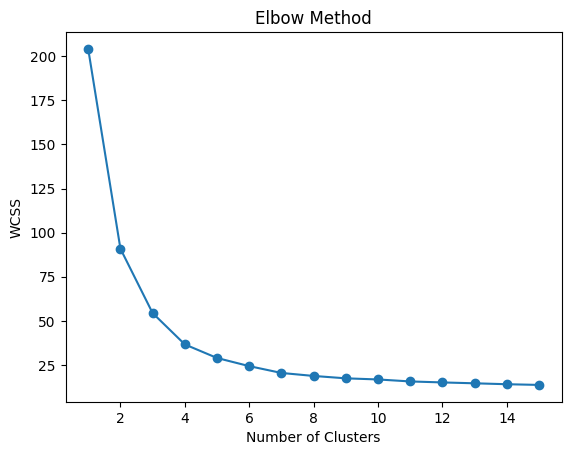

In [48]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from joblib import dump
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def extract_features(image_paths, model):
    features = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=(256, 256))  
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        feature = model.predict(image)
        features.append(feature.flatten())
    return np.array(features)

def load_model():
    base_model = InceptionV3(weights=None, include_top=False)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
               if os.path.isfile(os.path.join(image_folder, f)) 
               and f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'))]
pretrained_model = load_model()
features = extract_features(image_paths, pretrained_model)

wcss = []
max_clusters = 15  
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_) 
    
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()


In [59]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from joblib import dump
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

n_clusters = 20
best_silhouette_score = -1  

for _ in range(1):
    pretrained_model = InceptionV3(weights=None, include_top=False)
    x = pretrained_model.output
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=pretrained_model.input, outputs=x)

    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                   if os.path.isfile(os.path.join(image_folder, f)) 
                   and f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif'))]
    features = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=(256, 256))  
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        feature = model.predict(image)
        features.append(feature.flatten())
    features = np.array(features)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    silhouette_avg = silhouette_score(features, kmeans.labels_)
    print(f"Silhouette Score: {silhouette_avg}")
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_features = features
        best_kmeans = kmeans
        dump(kmeans, kmeans_model_path)

print(f"Best Silhouette Score: {best_silhouette_score}")


1/1 [==============================] - 0s 50ms/step


/Users/hanoon/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.17954571545124054
Best Silhouette Score: 0.17954571545124054


In [60]:
import pandas as pd
csv_output_path = 'clusters.csv'
image_cluster_mapping = pd.DataFrame({'Image_Path': image_paths, 'Cluster_Label': best_kmeans.labels_})
image_cluster_mapping.to_csv(csv_output_path, index=False)
print(f"Image-cluster mapping saved to {csv_output_path}")

Image-cluster mapping saved to clusters.csv


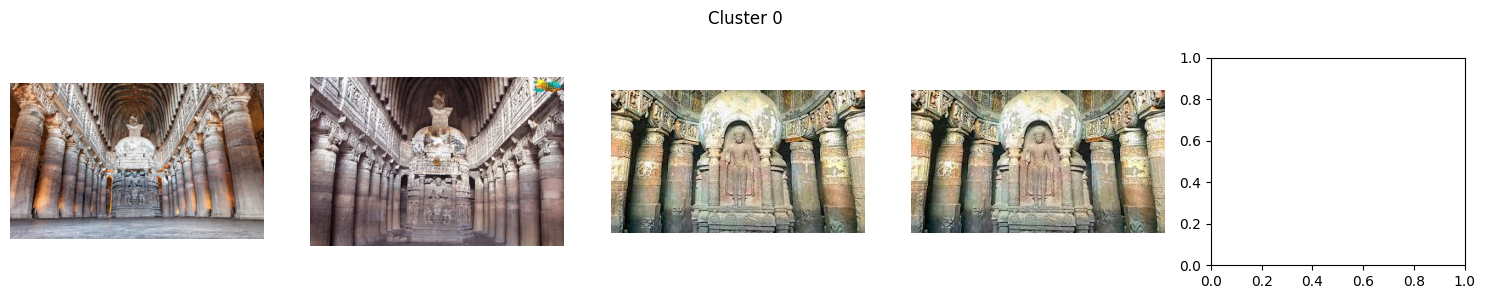

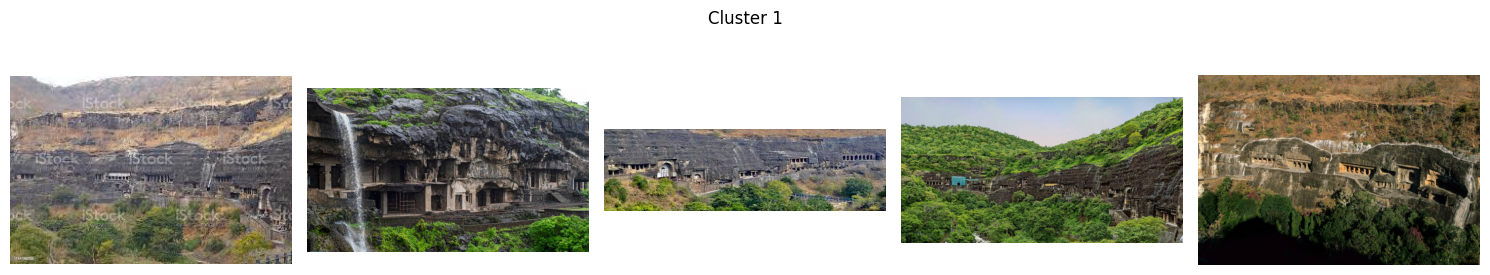

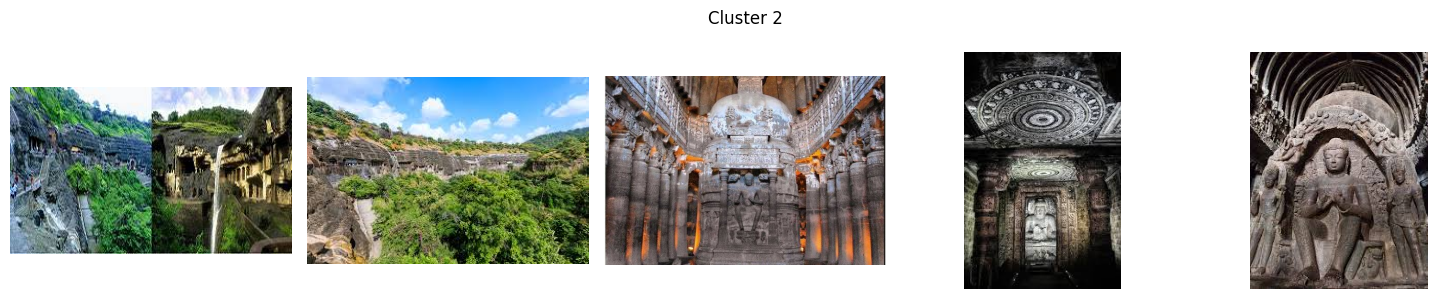

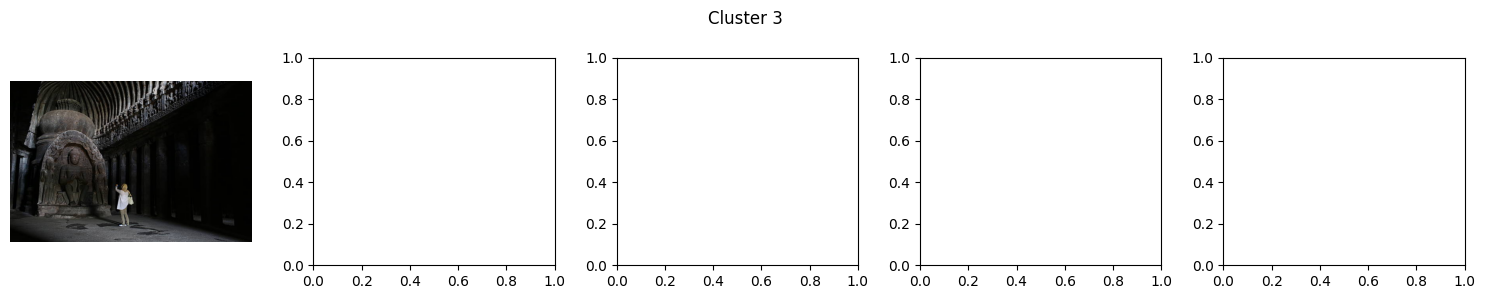

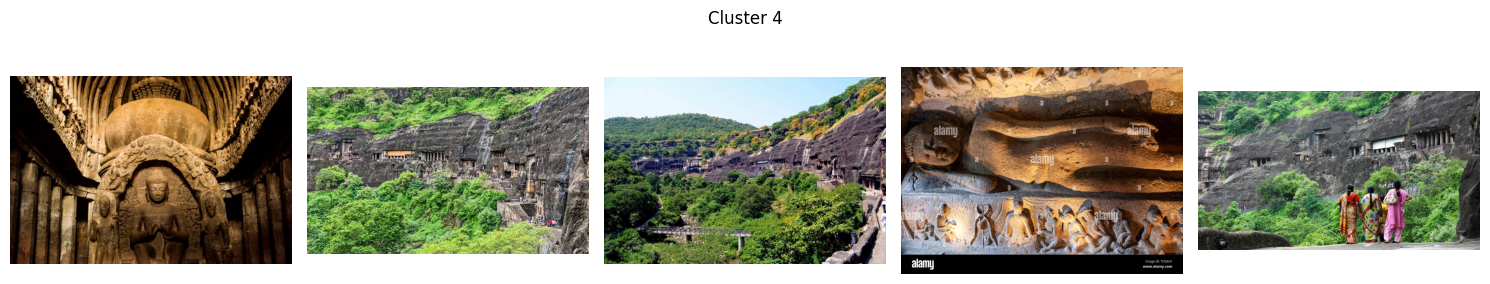

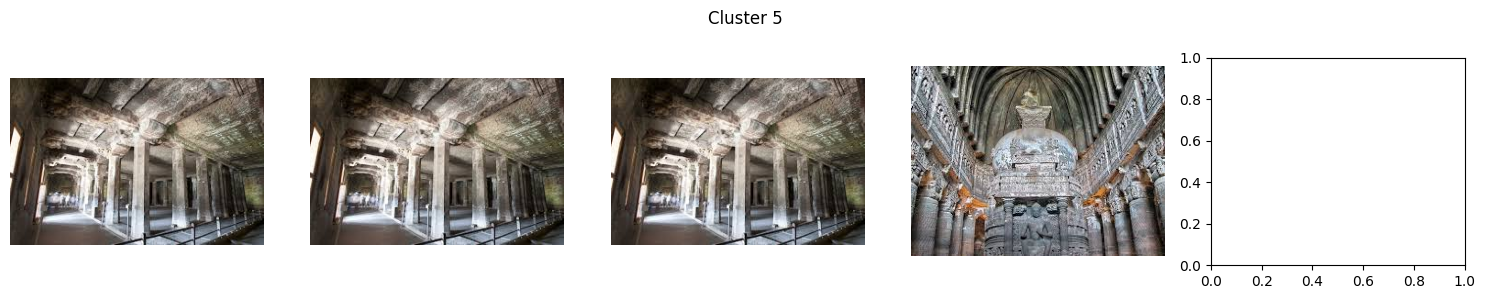

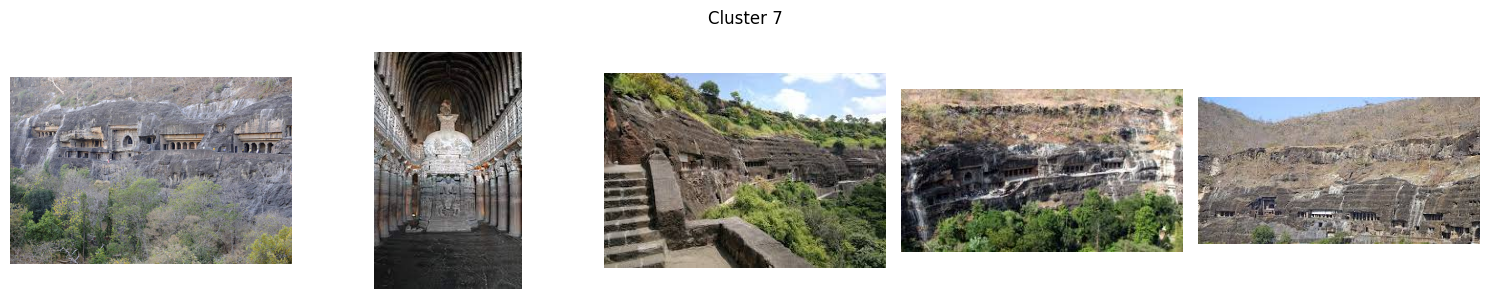

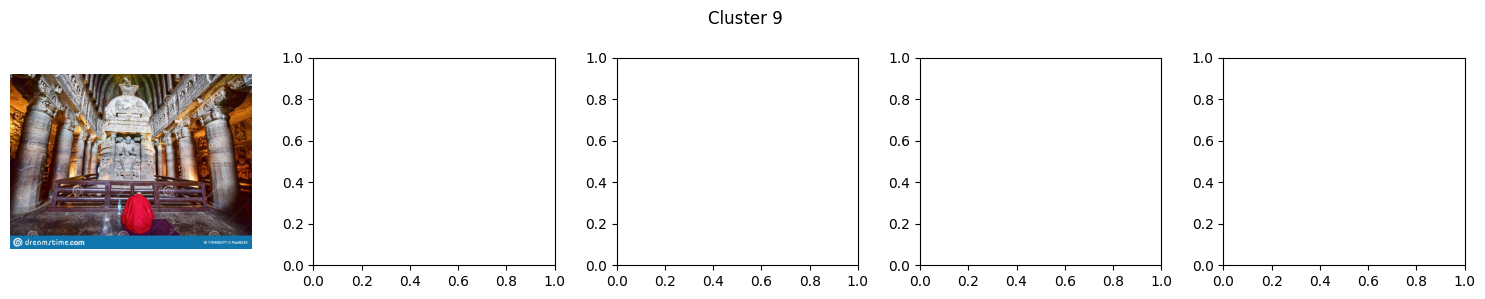

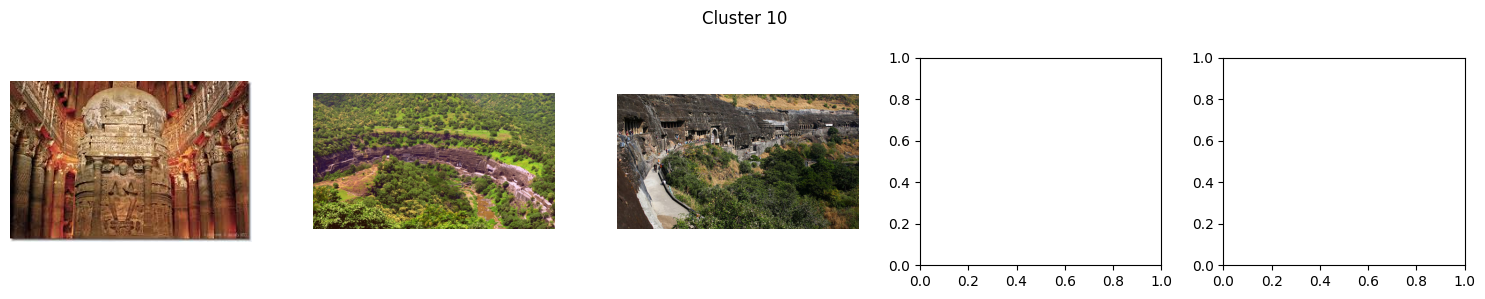

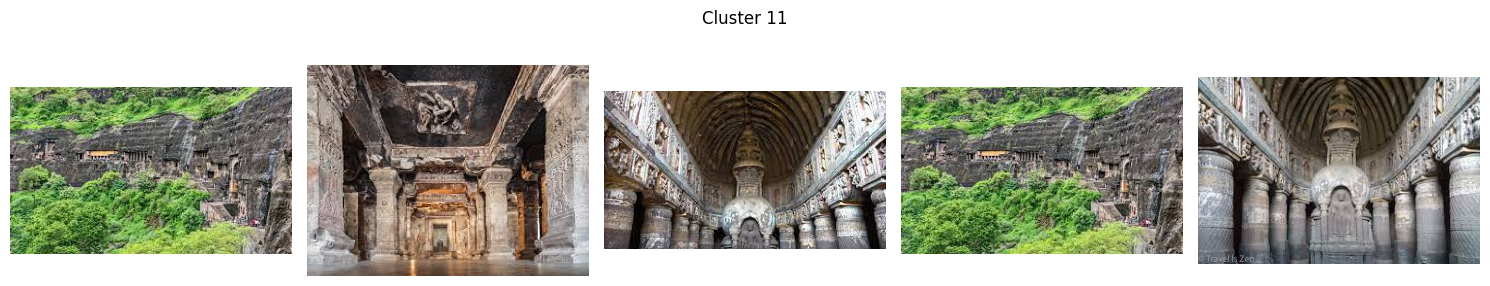

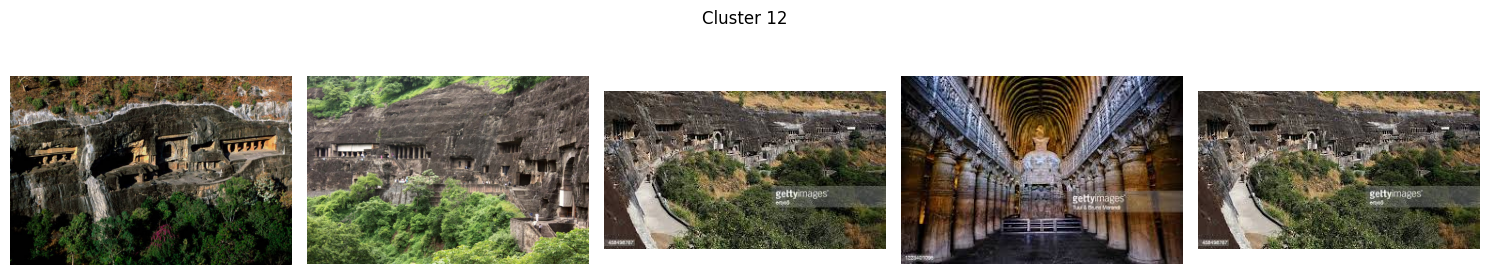

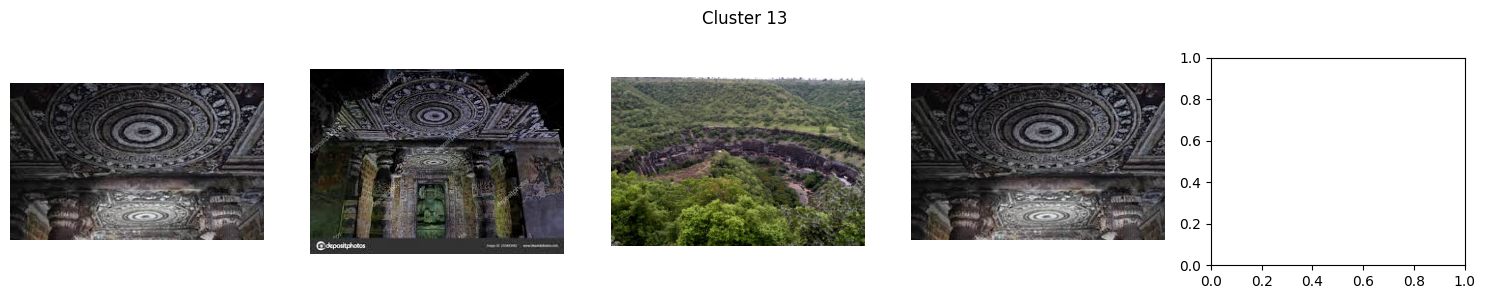

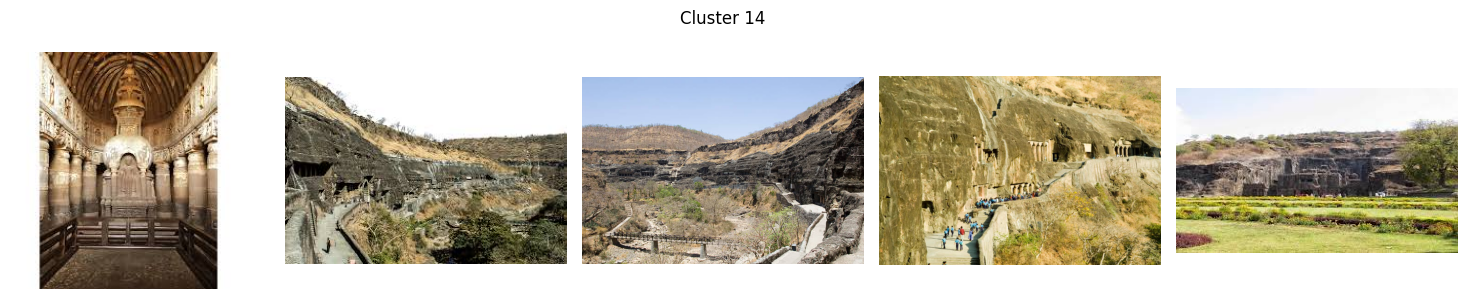

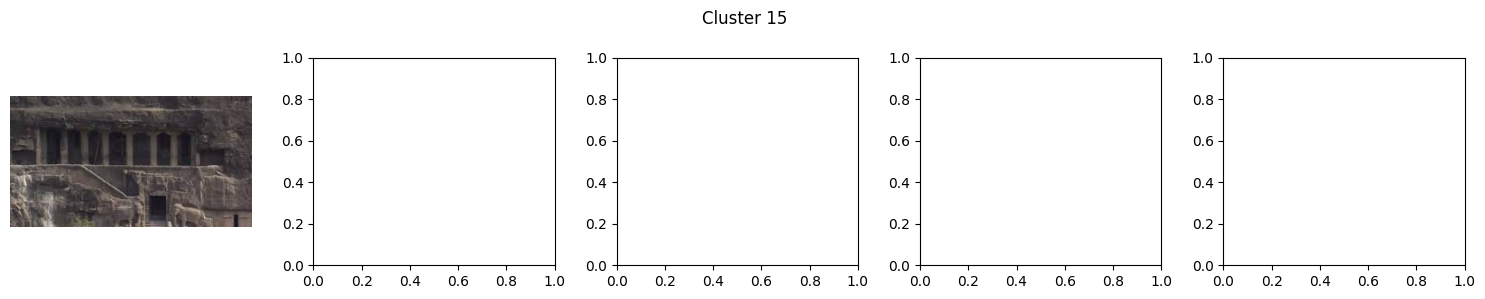

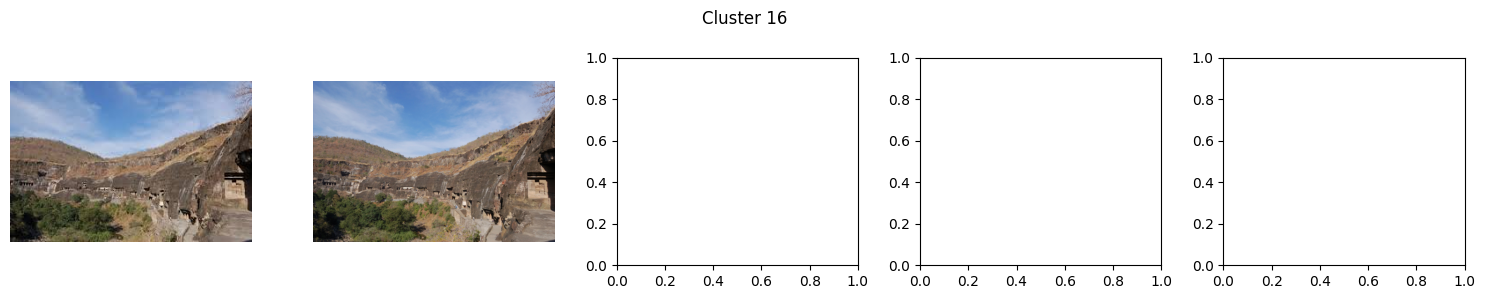

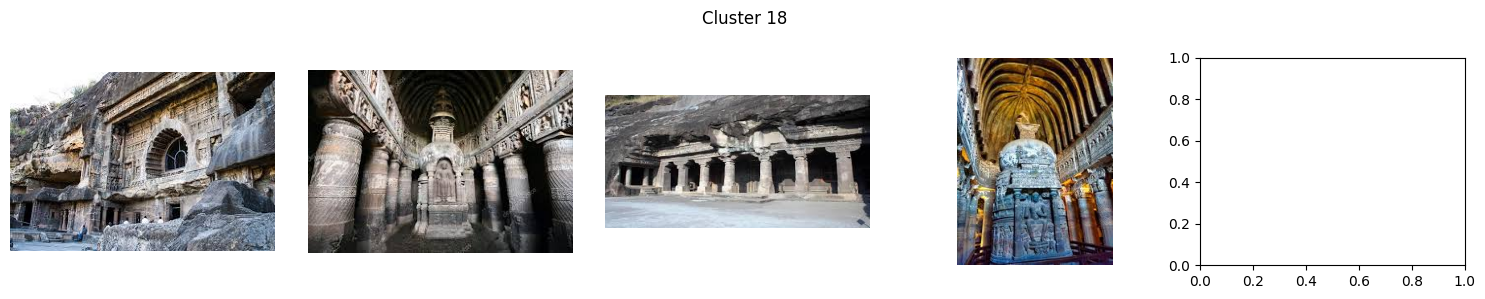

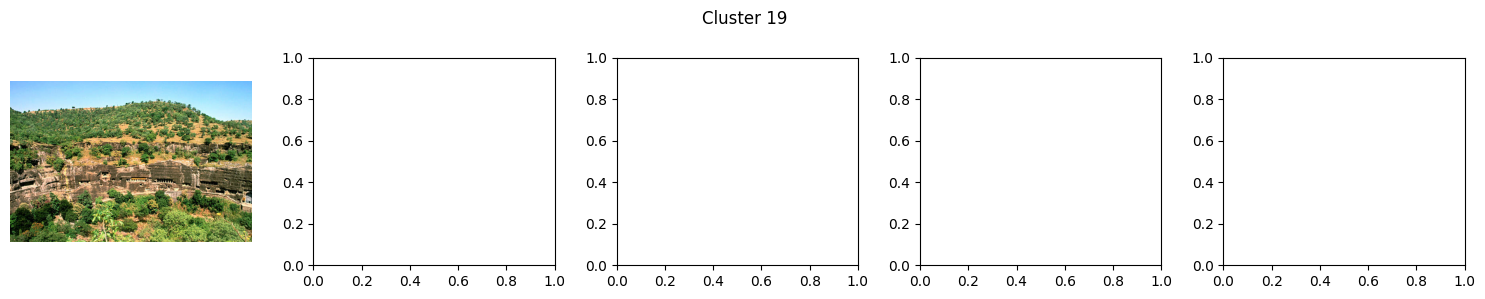

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import random

image_cluster_mapping = pd.read_csv('clusters.csv')
num_images_per_cluster = 5
cluster_groups = image_cluster_mapping.groupby('Cluster_Label')

for cluster_label, cluster_data in cluster_groups:
    random_images = cluster_data.sample(min(num_images_per_cluster, len(cluster_data)))
    fig, axes = plt.subplots(1, num_images_per_cluster, figsize=(15, 3))
    for i, (_, row) in enumerate(random_images.iterrows()):
        img = plt.imread(row['Image_Path'])
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle(f'Cluster {cluster_label}')
    plt.tight_layout()
    plt.show()